In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

In [2]:
data = pd.read_csv("day.csv")

data = data[['yr', 'season','mnth','holiday','weekday','workingday','weathersit','temp','atemp','hum','windspeed','cnt']]

X = data.drop(columns=['cnt'])
y = data['cnt']

categorical_cols = ['season','mnth','weekday','weathersit']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

scaler = StandardScaler()
numeric_cols = ['temp','yr','atemp','hum','windspeed','holiday','workingday']
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])

X = np.asarray(X_encoded, dtype=np.float64)
y = np.asarray(y, dtype=np.float64).reshape(-1, 1)


In [3]:
def predict(X, w, b):
    return np.dot(X, w) + b

def compute_cost(X, y, w, b):
    m = X.shape[0]
    predictions = predict(X, w, b)
    cost = (1/(2*m)) * np.sum((predictions - y)**2)
    return cost

def compute_gradient(X, y, w, b):
    m = X.shape[0]
    predictions = predict(X, w, b)
    error = predictions - y
    dj_dw = (1/m) * np.dot(X.T, error)
    dj_db = (1/m) * np.sum(error)
    return dj_dw, dj_db

def gradient_descent(X, y, w_in, b_in, alpha, num_iters):
    w = w_in.copy()
    b = b_in
    J_history = []
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(X, y, w, b)
        w -= alpha * dj_dw
        b -= alpha * dj_db
        cost = compute_cost(X, y, w, b) # added for cost_function
        J_history.append(cost)         

    return w, b, J_history 

Fold 1: R²=0.828, RMSE=830.62, MAE=621.49
Fold 2: R²=0.790, RMSE=873.79, MAE=655.01
Fold 3: R²=0.776, RMSE=921.23, MAE=682.57
Fold 4: R²=0.713, RMSE=946.97, MAE=705.60
Fold 5: R²=0.824, RMSE=832.54, MAE=635.36

=== Average Model Performance Across 5 Folds ===
Average R²   : 0.786 ± 0.042
Average RMSE : 881.03 ± 46.71
Average MAE  : 660.00 ± 30.67


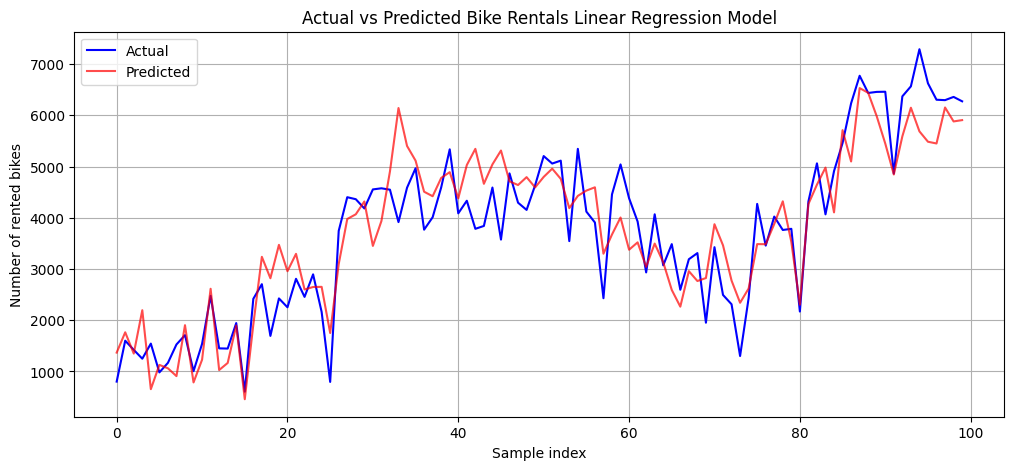

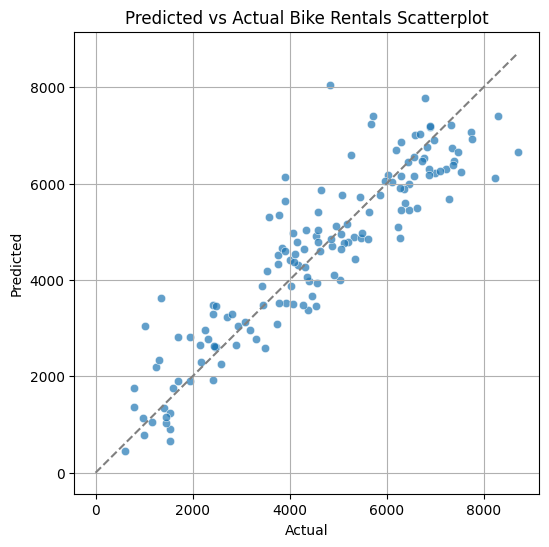

In [4]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
alpha = 0.01
iterations = 500
r2_scores, rmse_scores, mae_scores = [], [], []
fold = 1

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    n = X_train.shape[1]
    w = np.zeros((n, 1))
    b = 0.0

    w, b, lr_fold_history = gradient_descent(X_train, y_train, w, b, alpha, iterations)
    y_pred = predict(X_test, w, b)

    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Fold {fold}: R²={r2:.3f}, RMSE={rmse:.2f}, MAE={mae:.2f}")
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    fold += 1

print("\n=== Average Model Performance Across 5 Folds ===")
print(f"Average R²   : {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")
print(f"Average RMSE : {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")
print(f"Average MAE  : {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")

# VISUALIZE RESULTS
plt.figure(figsize=(12,5))
plt.plot(y_test[:100], label="Actual", color='blue')
plt.plot(y_pred[:100], label="Predicted", color='red', alpha=0.7)
plt.title("Actual vs Predicted Bike Rentals Linear Regression Model")
plt.xlabel("Sample index")
plt.ylabel("Number of rented bikes")
plt.legend()
plt.grid(True)
plt.show()

#scatter
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test.flatten(), y=y_pred.flatten(), alpha=0.7)
plt.plot([0, np.max(y_test)], [0, np.max(y_test)], '--', color='gray')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Bike Rentals Scatterplot")
plt.grid(True)
plt.show()